# Predicting ratings of Google Play Store apps

## Importing libraries

We will be using the following libraries:

- numpy - for numerical computations
- pandas - for data structures and data analysis
- matplotlib - for plotting
- tensorflow - for deep learning

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics

print(tf.__version__)

2.10.0


## Getting training and testing data

In [26]:
# Path to training and testing datasets
PATH_X_TRAIN = 'data/googleplaystore_X_train_encoded.csv'
PATH_Y_TRAIN = 'data/googleplaystore_y_train_encoded.csv'
PATH_X_TEST = 'data/googleplaystore_X_test_encoded.csv'
PATH_Y_TEST = 'data/googleplaystore_y_test_encoded.csv'

In [27]:
# Load training and testing datasets
X_train = pd.read_csv(PATH_X_TRAIN)
y_train = pd.read_csv(PATH_Y_TRAIN)
X_test = pd.read_csv(PATH_X_TEST)
y_test = pd.read_csv(PATH_Y_TEST)

## Regression using Deep Neural Network (DNN)

Feature selections: `Reviews`, `Size`, `Price`, `Category`, `Installs`, `Type`, `Content Rating`, `Primary Genre`, `Secondary Genre`

Response variable: `Rating`

Why DNN? The data is not linearly correlated, and we have a large number of features. DNN is a good choice for this problem.

There is no particular features that offer a visible correlation with the response variable. Therefore, we will use all the features. In addition, DNN may 'discover' some hidden correlations between the features and the response variable, or create a new and impactful feature from several of the provided features. Such flexibility allow us to use all the features.

### Building the model

In [28]:
def build_model():
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=[len(X_train.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=[
                    metrics.MeanAbsoluteError(name='mae'),
                    metrics.MeanSquaredError(name='mse')
                ])
    return model

Explanation of the model:
- The model has 4 hidden layers, with 64, 64, 64, and 1 neurons respectively. The last layer has only 1 neuron, as we are trying to predict a single value (rating). We have tested the model with different number of neurons per layer, and different number of layers, and found that all configurations perform similarly. Therefore, we choose this configuration as a reporesentative one.
- The activation function for the hidden layers is `relu`, and the activation function for the output layer is `linear`.
- The loss function is `mean_squared_error` (also used in linear regression problem), and the optimizer is `adam` (The optimizer is an algorithm that helps the model converges, "Adam" is selected because it saves time and is generally efficient).

We believe this configuration is a good and popular choice when it comes to regression problems.

In [29]:
dnn_model = build_model()
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               12800     
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 25,281
Trainable params: 25,281
Non-trainable params: 0
_________________________________________________________________


### Training the model

In [30]:
# Train the model
EPOCHS = 100
dnn_history = dnn_model.fit(
    X_train, y_train,
    epochs=EPOCHS, validation_split = 0.2, verbose=0
)

In [31]:
# Plot training and validation loss
def plot_loss(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error [Rating]')
    plt.plot(history.epoch, np.array(history.history['mse']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mse']),
           label = 'Val loss')
    plt.legend()
    plt.ylim([0, 1])

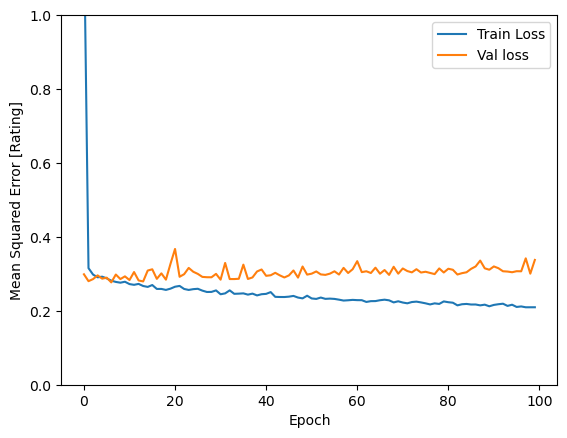

In [32]:
plot_loss(dnn_history)

As the model trains, the loss function (MSE) is minimized. This means the model is getting better at predicting the ratings. Note that the loss function decreases very rapidly during the first few epochs, and then it slows down. Validation loss, on the other hands, does not decrease at all. This means the model converged quickly, and is not improving anymore. We have achieved the optimal performance of the model.

### Evaluating the model

In [33]:
# Apply model to test set
test_results = dnn_model.evaluate(X_test, y_test, verbose=0)
print('Mean Absolute Error on test set: {}'.format(test_results[1]))
print('Mean Squared Error on test set (used as loss function): {}'.format(test_results[2]))

Mean Absolute Error on test set: 0.4240374267101288
Mean Squared Error on test set (used as loss function): 0.3146454095840454


**Remark:** The model has a mean absolute error of 0.4, which is not bad. It means the model can predict the rating of an app (on the scale of 1 - 5) with an error of 0.4 stars. Practically, we think this error is acceptable, and results from this model can be considered reliable. Out of the models we tried, this is among the best ones (lowest errors), comparable to the random forest model and outperforming the XGBoost model.